<a href="https://colab.research.google.com/github/kingattai/urinary-tract-infection-prediction-ml-xai/blob/main/DT_Conference_UTI_with_RiskFactors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install treeinterpreter

In [ ]:
!pip install imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, log_loss, classification_report,
                             confusion_matrix, roc_auc_score)
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from treeinterpreter import treeinterpreter as ti
from sklearn.inspection import PartialDependenceDisplay

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1. Load dataset
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NFRF ML/UTI_Data.csv')
df2 = df.drop(df.columns[0], axis=1)  # Drop first index/ID column

In [ ]:
# 3. Split into features and target
X = df2.iloc[:, :-1].values
y = df2.iloc[:, -1].values

In [ ]:
# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", np.bincount(y_train_smote))

Class distribution after SMOTE: [3129 3129]


In [ ]:
dt = DecisionTreeClassifier(random_state=42)
param_grid_dt = {'max_depth': [None, 10, 20]}
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(X_train_smote, y_train_smote)
best_dt_model = grid_search_dt.best_estimator_

In [ ]:
# Prediction and Evaluation
y_pred_dt = best_dt_model.predict(X_test)
y_prob_dt = best_dt_model.predict_proba(X_test)
print("Best parameters:", grid_search_dt.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_dt, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_dt, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_dt, average='weighted'):.4f}")
print(f"Log Loss: {log_loss(y_test, y_prob_dt):.4f}")
if len(np.unique(y_test)) == 2:
    print(f"AUC-ROC: {roc_auc_score(y_test, y_prob_dt[:, 1]):.4f}")

Best parameters: {'max_depth': 20}

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88       775
           1       0.53      0.64      0.58       198

    accuracy                           0.81       973
   macro avg       0.72      0.75      0.73       973
weighted avg       0.83      0.81      0.82       973

Accuracy: 0.8129
Precision: 0.8282
Recall: 0.8129
F1 Score: 0.8191
Log Loss: 5.5892
AUC-ROC: 0.7263


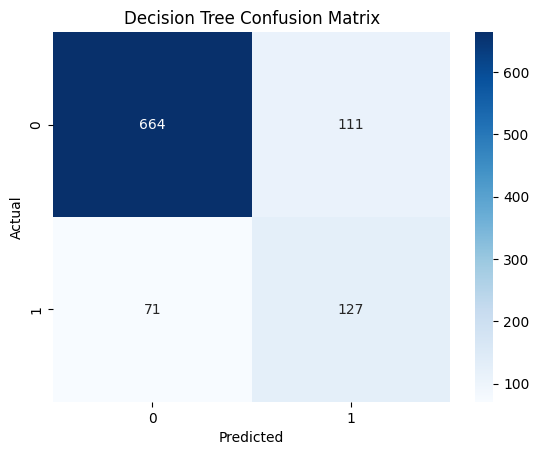

In [ ]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Decision Tree Confusion Matrix')
plt.show()

In [ ]:
# TreeInterpreter
instance = X_test[0:1]
prediction, bias, contributions = ti.predict(best_dt_model, instance)
print("\n🌳 TreeInterpreter (Instance 0)")
print(f"Prediction: {prediction[0]}")
print(f"Bias: {bias[0]}")
for i, c in enumerate(contributions[0]):
    print(f"Feature {i} contributions per class: {[round(val, 4) for val in c]}")


🌳 TreeInterpreter (Instance 0)
Prediction: [0. 1.]
Bias: [0.5 0.5]
Feature 0 contributions per class: [np.float64(0.0), np.float64(0.0)]
Feature 1 contributions per class: [np.float64(0.0), np.float64(0.0)]
Feature 2 contributions per class: [np.float64(0.0), np.float64(0.0)]
Feature 3 contributions per class: [np.float64(-0.0116), np.float64(0.0116)]
Feature 4 contributions per class: [np.float64(0.0), np.float64(0.0)]
Feature 5 contributions per class: [np.float64(0.0), np.float64(0.0)]
Feature 6 contributions per class: [np.float64(0.0), np.float64(0.0)]
Feature 7 contributions per class: [np.float64(0.0), np.float64(0.0)]
Feature 8 contributions per class: [np.float64(-0.0542), np.float64(0.0542)]
Feature 9 contributions per class: [np.float64(-0.1), np.float64(0.1)]
Feature 10 contributions per class: [np.float64(-0.4218), np.float64(0.4218)]
Feature 11 contributions per class: [np.float64(0.0), np.float64(0.0)]
Feature 12 contributions per class: [np.float64(0.0), np.float64(0.0

In [ ]:
# Use instance 0 from the test set
instance = X_test[0:1]

# Predict and get contributions
prediction, bias, contributions = ti.predict(best_dt_model, instance)

# Rank contributions by magnitude
contrib_class = contributions[0][:, 1]  # For positive class (class 1)
sorted_idx = np.argsort(np.abs(contrib_class))[::-1]

print("\n Top Contributing Features for Class 1 Prediction:")
for idx in sorted_idx:
    print(f"Feature {idx} contribution: {contrib_class[idx]:.4f}")


 Top Contributing Features for Class 1 Prediction:
Feature 10 contribution: 0.4218
Feature 9 contribution: 0.1000
Feature 16 contribution: -0.0875
Feature 8 contribution: 0.0542
Feature 3 contribution: 0.0116
Feature 17 contribution: 0.0000
Feature 18 contribution: 0.0000
Feature 12 contribution: 0.0000
Feature 13 contribution: 0.0000
Feature 14 contribution: 0.0000
Feature 15 contribution: 0.0000
Feature 11 contribution: 0.0000
Feature 7 contribution: 0.0000
Feature 5 contribution: 0.0000
Feature 6 contribution: 0.0000
Feature 4 contribution: 0.0000
Feature 2 contribution: 0.0000
Feature 1 contribution: 0.0000
Feature 0 contribution: 0.0000


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=ec112d593aae72e9a0823a76f8de8103efe1fa770623ecd4b4b6616597d0ef3c
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import lime
import lime.lime_tabular

In [ ]:
# If you used NumPy arrays, convert to DataFrame for feature names
if isinstance(X_train, np.ndarray):
    feature_names = df2.dropna(axis=1).columns[:-1]  # Exclude target column
    X_train_df = pd.DataFrame(X_train, columns=feature_names)
    X_test_df = pd.DataFrame(X_test, columns=feature_names)
else:
    feature_names = X_train.columns
    X_train_df = X_train
    X_test_df = X_test

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_df.values,
    feature_names=feature_names,
    class_names=['No Disease', 'Disease'],
    mode='classification',
    discretize_continuous=True
)


 LIME Explanation (Decision Tree):


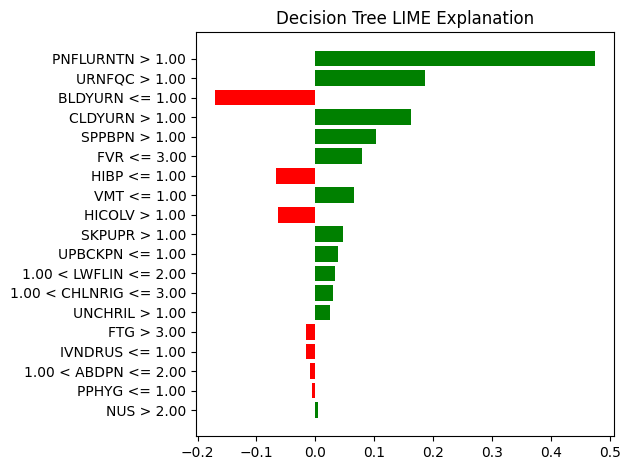

In [ ]:
# Explain prediction for the first test instance
i = 0
exp_dt = explainer.explain_instance(
    X_test_df.iloc[i].values,
    best_dt_model.predict_proba,  # assuming you did grid search or fitted as best_dt_model
    num_features=len(feature_names)
)

# Show explanation
print("\n LIME Explanation (Decision Tree):")
fig = exp_dt.as_pyplot_figure()
plt.title("Decision Tree LIME Explanation")
plt.tight_layout()
plt.show()